# Notebook for analysis

In [1]:
import pickle
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.colors as mcolors
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

sns.set_context('paper')
%matplotlib inline

# 1 Single neuron HH

desscribe the neuron's of hodgkin-huxley with their ionic currents.

the phase espaces and fixed points.

# 1 Single neuron HH

Describing the Hodgkin-Huxley neurons with their ionic currents and frequency of spike for each current external injected.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

os.chdir('PospischilEtAl2008')

import neuron as nrn # NEURON simulator
nrn.h.load_file("mosinit.hoc");
nrn.h.load_file("demo_PY_IBR.hoc");

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


	1 
	1 
	1 
	1 
 
>> Transient time of 0  ms
 
 
<<==================================>>
<<            CREATE CELLS          >>
<<==================================>>
 
 
 << defining template for one-compartment sPY cell >> 
 
	1 
 
<< sPY: passive, INa, IK, IM inserted >>
 
	1 
Select a cell then press Init & Run button
	1 
 
>> Transient time of 0  ms
 
 
<<==================================>>
<<            CREATE CELLS          >>
<<==================================>>
 
 
 << defining template for one-compartment sPYb cell >> 
 
	1 
 
<< sPYr: passive, INa, IK, Ca++, IT inserted >>
 


Create Soma and insert mechanisms

In [3]:
def create_soma(verbose=False):
    soma = nrn.h.Section(name='soma')
    soma.nseg = 1 #
    soma.diam = 96 #
    soma.L = 96 #			// so that area is about 29000 um2
    soma.cm = 1 #
    soma.Ra = 100 #		// geometry 

    if verbose:
        print("- Soma object:", soma)
        print("- Number of segments in the soma:", soma.nseg)
        print(f'- Diam: {soma.diam} | L: {soma.L} | cm: {soma.cm} | Ra: {soma.Ra}')
    return soma

def insert_mechanisms(soma, hh2=True, pas=True, im=True, it=True, il=True, return_mechs = False):
    if pas:
        soma.insert('pas')
        soma.e_pas = -85
        soma.g_pas = 1e-5 #		// idem TC cell

    if hh2:
        soma.insert('hh2'); #		// Hodgin-Huxley INa and IK 
        soma.ek = -100 #		// potassium reversal potential 
        soma.ena = 50 #			// sodium reversal potential 
        soma.vtraub_hh2 = -55 #	// Resting Vm, BJ was -55
        soma.gnabar_hh2 = 0.05 #	// McCormick=15 muS, thal was 0.09
        soma.gkbar_hh2 = 0.005 #	// spike duration of pyr cells
        celsius = 36
        v_init = -84
    
    if im:
        soma.insert('im'); #		// M current 
        taumax_im = 1000
        soma.gkbar_im = 3e-5 #		// specific to LTS pyr cell
    
    if it:
        soma.insert('it'); #// IT current 
        soma.cai = 2.4e-4 
        soma.cao = 2 
        #eca = 120 
        soma.gcabar_it = 0.0004 #// specific to LTS pyr cell

    if il:
        soma.insert('ical'); #// IL current (Reuveni et al. model, Nernst)
        soma.cai = 2.4e-4 
        soma.cao = 2 
        #soma.eca = 120 
        soma.gcabar_ical = 2.2e-4

        soma.insert('cad');  #		// calcium decay
        soma.depth_cad = 1 #		// McCormick= 0.1 um
        soma.taur_cad = 5 #		// McCormick=1 ms !!!
        soma.cainf_cad = 2.4e-4 #	// McCormick=0
        soma.kt_cad = 0 #		// no pump
        soma.depth_cad = 1 #		// McCormick= 0.1 um
    
    
    if return_mechs:
        return soma, hh2, pas, im, it, il
    else:
        return soma

In [4]:
def simConfig(soma, t, amp, dur, delay, return_channels=False, verbose=False):
    # Simulations Config
    ## Runs:
    nrn.h.tstop = t
    nrn.h.dt = 0.01

    iclamp = nrn.h.IClamp(.5, sec=soma)
    iclamp.amp = amp # nA
    iclamp.delay = delay # ms
    iclamp.dur = dur # ms

    #### Vectors
    time = nrn.h.Vector()
    voltage = nrn.h.Vector()
    stim_current = nrn.h.Vector()

    time.record(nrn.h._ref_t)
    voltage.record(soma(.5)._ref_v);
    stim_current.record(iclamp._ref_i)

    mechs_ionic = {}
    for mechs, param_mechs in soma.psection()['density_mechs'].items():
        for key_mechs in param_mechs.keys():
            if key_mechs in ['m','n','h']:
                # find the mechanisms and create a vector to record data.
                mechs_ionic[f'{key_mechs}_{mechs}'] = nrn.h.Vector()

    channels = {}
    for channel, mechs in mechs_ionic.items():
        # for every ionic mechanism, get the attribute and record it
        ref_record = getattr(soma(.5), f'_ref_{channel}')
        channels[channel] = mechs.record(ref_record);
        if verbose:
            print(f'--> mechanism {mechs_ionic} of soma is recorded...')

    if verbose:
        print("- Simulation stop time: %f ms" % nrn.h.tstop)
        print("- Integration time step: %f ms" % nrn.h.dt)
        print("- Amplitude external current: %f nA" % iclamp.amp)
        print("- Duration external current: %f ms" % iclamp.dur)
        print("- Delay external current: %f ms" % iclamp.delay)
        print('- Return Channels: ', return_channels)
    nrn.h.run()
    
    if return_channels:
        return time, voltage, stim_current, channels
    else:
        return time, voltage, stim_current

def plot_tv(time_array, voltage_array, show=True, label=None, figsize=(10,3), color='black',
            ylabel='Membrane voltage (mV)', xyaxis=[2690, 3000, -85, 50], constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.figure(figsize=figsize)
    plt.plot(time_array, voltage_array, label=label, color=color, linewidth=0.7)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.axis(xyaxis)
    if show:
        plt.show()

def plot_voltage_stim(time_array, voltage_array, stim_array, figsize=(10,3)):
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, (ax0, ax1) = plt.subplots(2,1, figsize=figsize, gridspec_kw = {'height_ratios':[3, 1]})
    sns.lineplot(x = time_array, y =voltage_array, color='black', ax=ax0)
    ax1.plot(time_array,stim_array, 'gray')

    ax0.set_ylim(-90, 55)
    ax0.set_ylabel('Voltage (mV)')
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.get_xaxis().set_visible(False)


    ax1.plot([0,0],[0,0.15],'k')
    ax1.text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax1.set_ylabel('Injected current (nA)')
    ax1.set_xlabel('Time (ms)')

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_channels(channels, time_array, stim_array, title=None, figsize=(10,3)):
    import matplotlib.colors as mcolors
    cores = list(mcolors.TABLEAU_COLORS.keys())
    cores = [cor.split(':')[-1] for cor in cores]
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, ax = plt.subplots(nrows=int(len(channels)+1), ncols=1, figsize=figsize)
    for i, (axis, (channel, value)) in enumerate(zip(ax[:-1], channels.items())):
        sns.lineplot(x = time_array, y =value, color=cores[i], ax=axis, label=f'{channel}'.replace('_', ' '))
        #axis.set_xlim(-5,time_array[-1])
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.get_xaxis().set_visible(False)
        axis.legend(loc='lower left')
    ax[-1].plot(time_array,stim_array, 'gray')
    ax[-1].plot([0,0],[0,0.15],'k')
    ax[-1].text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax[-1].set_ylabel('Injected current (nA)')
    ax[-1].set_xlabel('Time (ms)')

    ax[-1].spines['right'].set_visible(False)
    ax[-1].spines['top'].set_visible(False)
    ax[-1].spines['left'].set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [5]:
import scipy

def spike_frequency(time, voltage, threshold = 0 , mth=1):
    # to arrays
    time, voltage = np.array(time), np.array(voltage)

    # Definir limiar de disparo
    limiar = threshold  # mV

    # Identificar picos de voltagem
    spikes, _ = scipy.signal.find_peaks(voltage, height=limiar)

    if len(spikes) > mth:
        # Calcular a frequência de disparos
        frequencia = len(spikes[mth:]) / (time[-1] - time[0])  # em Hz m^-3 
        return frequencia
    else:
        return 0 

def coefficient_variation(time, voltage, threshold = 0, mth=1):
    # to arrays
    time, voltage = np.array(time), np.array(voltage)
    
    # Definir limiar de disparo
    limiar = threshold  # mV

    # Identificar picos de voltagem
    spikes, _ = scipy.signal.find_peaks(voltage, height=limiar)
    
    if len(spikes) > mth:
        spkt = time[spikes[mth:]]
        ISI = np.array([s - f for f, s in zip(spkt[:], spkt[1:])])

        cv = ISI.std() / ISI.mean()
        return cv
    else:
        return 0

def spikes_analysis(soma, t, min_stim, max_stim, step=0.005,  mth_spikes=False):
    if t < 1000:
        raise Exception('tempo pequeno.') 
    if not mth_spikes:
        amps = np.arange(min_stim, max_stim, step)
        spikes_freq = np.zeros_like(amps)
        coef_variation = np.zeros_like(amps)

        for i, amp in enumerate(amps):
            time, voltage, _ = simConfig(soma, t, amp, t-1000, 500, return_channels=False)
            spikes_freq[i] = spike_frequency(time, voltage) * 10**3
            coef_variation[i] = coefficient_variation(time, voltage)

        return amps, spikes_freq, coef_variation
    else:
        freq_mth, coef_variation_mth = {},{}
        for mth in mth_spikes:
            amps = np.arange(min_stim, max_stim, step)
            spikes_freq = np.zeros_like(amps)
            coef_variation = np.zeros_like(amps)

            for i, amp in enumerate(amps):
                time, voltage, _ = simConfig(soma, t, amp, t-1000, 500, return_channels=False)
                spikes_freq[i] = spike_frequency(time, voltage, mth=mth) * 10**3
                coef_variation[i] = coefficient_variation(time, voltage, mth=mth)
            freq_mth[mth] = spikes_freq
            coef_variation_mth[mth] = coef_variation

        return amps, freq_mth, coef_variation_mth

In [6]:
## Plots
def plot_tv(time_array, voltage_array, show=True, label=None, figsize=(10,3), color='black',
            ylabel='Membrane voltage (mV)', xyaxis=[2690, 3000, -85, 50], constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.figure(figsize=figsize)
    plt.plot(time_array, voltage_array, label=label, color=color, linewidth=0.7)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.axis(xyaxis)
    if show:
        plt.show()

def plot_voltage_stim(time_array, voltage_array, stim_array, title, figsize=(10,3)):
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, (ax0, ax1) = plt.subplots(2,1, figsize=figsize, gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title)
    sns.lineplot(x = time_array, y =voltage_array, color='black', ax=ax0)
    ax1.plot(time_array,stim_array, 'gray')

    ax0.set_ylim(-90, 55)
    ax0.set_ylabel('Voltage (mV)')
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.get_xaxis().set_visible(False)


    ax1.plot([0,0],[0,0.15],'k')
    ax1.text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax1.set_ylabel('Injected current (nA)')
    ax1.set_xlabel('Time (ms)')

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_channels(channels, time_array, stim_array, title=None, figsize=(10,3)):
    import matplotlib.colors as mcolors
    cores = list(mcolors.TABLEAU_COLORS.keys())
    cores = [cor.split(':')[-1] for cor in cores]
    #------------------------------------------------------------------------------
    # Plot figure
    #------------------------------------------------------------------------------
    f, ax = plt.subplots(nrows=int(len(channels)+1), ncols=1, figsize=figsize)
    for i, (axis, (channel, value)) in enumerate(zip(ax[:-1], channels.items())):
        sns.lineplot(x = time_array, y =value, color=cores[i], ax=axis, label=f'{channel}'.replace('_', ' '))
        #axis.set_xlim(-5,time_array[-1])
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.get_xaxis().set_visible(False)
        axis.legend(loc='lower left')
    ax[-1].plot(time_array,stim_array, 'gray')
    ax[-1].plot([0,0],[0,0.15],'k')
    ax[-1].text(20,stim_array.max()+0.03,f'{stim_array.max():.2f}nA',va='center')
    ax[-1].set_ylabel('Injected current (nA)')
    ax[-1].set_xlabel('Time (ms)')

    ax[-1].spines['right'].set_visible(False)
    ax[-1].spines['top'].set_visible(False)
    ax[-1].spines['left'].set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plot_freq_current(amp, freq, figsize=(5,3)):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, sharex=True)
    ax.set_title('Frequency by current injected'.title())
    sns.lineplot(y=freq, x=amp, ax=ax, color='black', linewidth=0.7)
    sns.scatterplot(y=freq, x=amp, ax=ax, color='red')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Injected current (nA)')
    plt.show()

def plot_cv_current(amp, coef_variation, figsize=(5,3)):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, sharex=True)
    ax.set_title('Coeficient of Variation by current injected'.title())
    sns.lineplot(y=coef_variation, x=amp, ax=ax, color='black', linewidth=0.7)
    sns.scatterplot(y=coef_variation, x=amp, ax=ax, color='red')
    ax.set_ylabel('Coeficient of Variation')
    ax.set_xlabel('Injected current (nA)')
    plt.show()

def plot_freq_cv_mthspike(amps, spikes_freq, coef_variation):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

    for mth, freq in spikes_freq.items():
        sns.lineplot(y=freq, x=amps, ax=ax[0], linewidth=0.7)
        sns.scatterplot(y=freq, x=amps, label=f'{mth}º spike', ax=ax[0])
        
    for mth, cv in coef_variation.items():
        sns.lineplot(y=cv, x=amps, ax=ax[1], linewidth=0.7)
        sns.scatterplot(y=cv, x=amps, label=f'{mth}º spike', ax=ax[1])
        

    ax[0].set_xlabel('Injected current (nA)')
    ax[0].set_ylabel('Frequency Spike (Hz)')

    ax[1].set_xlabel('Injected current (nA)')
    ax[1].set_ylabel('Coeficient of Variation')
    


## Hodgkin-Huxley neuron adapted by Traub and Miles 1991

$$I_\text{total} = I_\text{Na} +I_\text{K}$$



\begin{equation}
    I_\text{Na} = \bar{g}_\text{Na}m^3h(V-E_\text{Na}),  
\end{equation}

\begin{equation*}
    \frac{dm}{dt} = \alpha_m(V)(1 - m)-\beta_m(V)m,
\end{equation*}

\begin{equation*}
    \frac{dh}{dt} = \alpha_h(V)(1 - h)-\beta_h(V)h,
\end{equation*}

%% auxiliary potassium equations
\begin{equation*}
    \alpha_m = \frac{-0.32(V - V_T - 13)}{\text{exp}[-(V- V_T - 13)/4] - 1},
\end{equation*}

\begin{equation*}
    \beta_m = \frac{0.28(V-V_T-40)}{\text{exp}[(V-V_T-40)/5] - 1},
\end{equation*}

\begin{equation*}
    \alpha_h = 0.128\text{exp}[-(V - V_T - 17)/18],
\end{equation*}

\begin{equation*}
    \beta_h = \frac{4}{1+ \text{exp}[-(V-V_T - 40/5)]},
\end{equation*}


\begin{equation}
    I_{\text{K}} = \bar{g}_\text{K}n^4(V - E_\text{K}),
\end{equation}

\begin{equation*}
    \frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V)n
\end{equation*}

\begin{equation*}
    \alpha_n = \frac{-0.032(V - V_T - 15)}{\text{exp}[-(V - V_T - 15)/5]-1},
\end{equation*}

\begin{equation*}
    \beta_n = 0.5\text{exp}[-(V - V_T - 10)/40].
\end{equation*}


In [7]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=False, il=False, it=False)
time, voltage, stim, channels = simConfig(soma, 2000, 0.09, 1800, 100, return_channels=True)

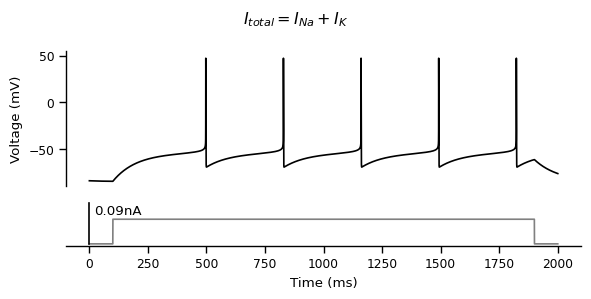

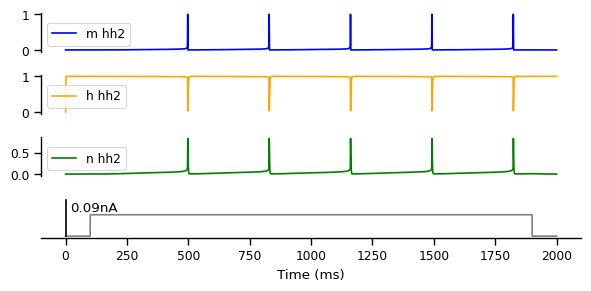

In [8]:
plot_voltage_stim(time, voltage, stim, title='$I_{total} = I_{Na} + I_{K}$',figsize=(6,3))
plot_channels(channels, time, stim, figsize=(6,3))

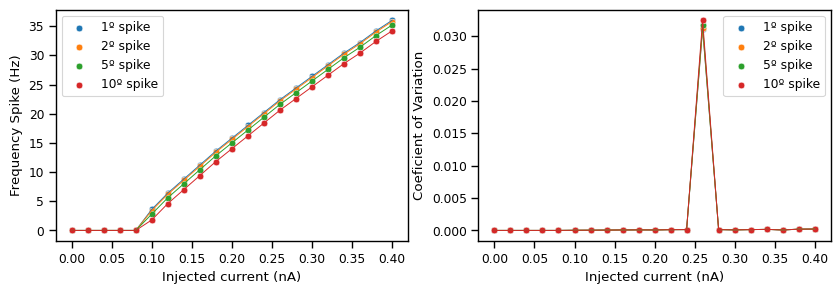

In [9]:
amps, spikes_freq, coef_variation = spikes_analysis(soma, 5000, 0.00, 0.42, step=0.02, mth_spikes=[1,2,5,10])
plot_freq_cv_mthspike(amps, spikes_freq, coef_variation)

In [10]:
amps, spikes_freq, coef_variation = spikes_analysis(soma, 5000, 0.00, 0.42, step=0.02)


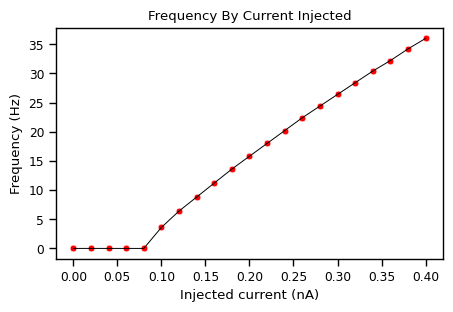

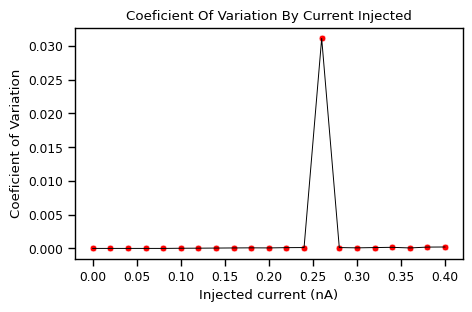

In [11]:
plot_freq_current(amps, spikes_freq)
plot_cv_current(amps, coef_variation)

## Traub Miles and Slow potassium currents for spike-frequency adaptation by Yamada et al. 1989

In [12]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=True, il=False,  it=False)
time, voltage, stim, channels = simConfig(soma, 3000, 0.15, 2000, 500, return_channels=True)

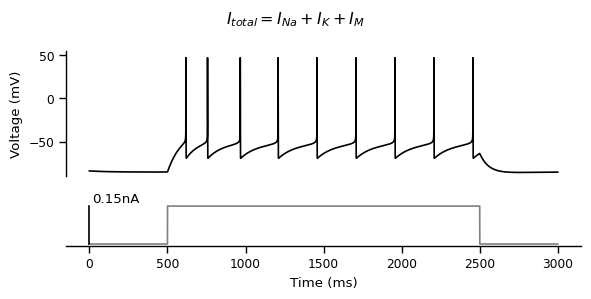

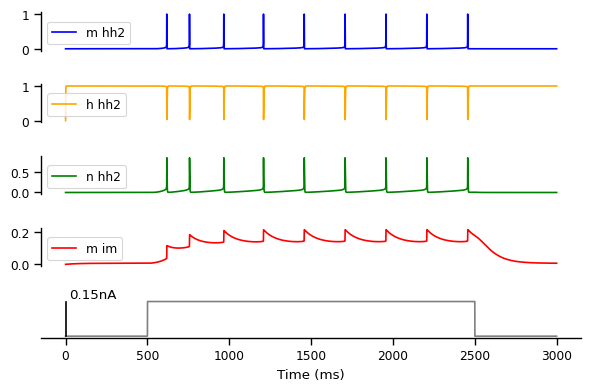

In [13]:
plot_voltage_stim(time,voltage,stim, figsize=(6,3), title='$I_{total} = I_{Na} + I_{K} + I_{M}$')
plot_channels(channels, time, stim, figsize=(6,4))

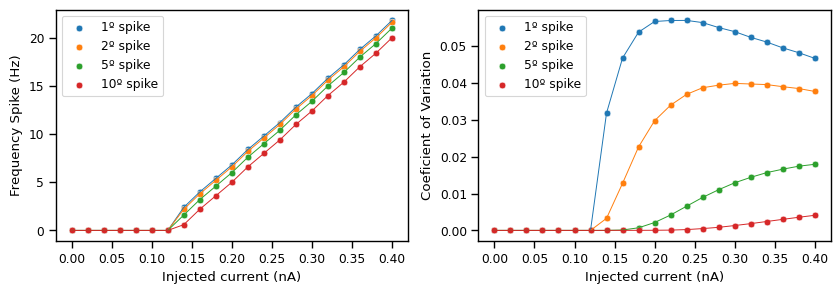

In [14]:
amps, spikes_freq, coef_variation = spikes_analysis(soma, 5000, 0.00, 0.42, step=0.02, mth_spikes=[1,2,5,10])
plot_freq_cv_mthspike(amps, spikes_freq, coef_variation)

## Traub-Miles + Yamada + Calsium high-threshold currents to generate bursting by Reuveni et al. 1993

$$I_\text{total} = I_\text{Na}+ I_\text{K} + I_M + I_L$$

\begin{equation}
    I_\text{L} = \bar{g}_\text{L} q^{2} r (V - E_\text{Ca}),
\end{equation}

\begin{equation*}
    \frac{dq}{dt} = \alpha_{q} (V)(1 - q) - \beta_q(V)q,
\end{equation*}

\begin{equation*}
    \frac{dr}{dt} = \alpha_r (V)(1- r) \beta_r(V)r,
\end{equation*}

\begin{equation*}
    \alpha_q = \frac{0.055(-27-V)}{\text{exp}[(-27-V)/3.8]-1},
\end{equation*}

\begin{equation*}
    \beta_q = 0.94\text{ exp}[(-75-V)/17],
\end{equation*}

\begin{equation*}
    \alpha_r = 0.000457\text{ exp}[(-13-V)/50],
\end{equation*}

\begin{equation*}
    \beta_r = \frac{0.0065}{\text{exp}[(-15-V)/28] + 1},
\end{equation*}

In [15]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=True, il=True, it=False)
time, voltage, stim, channels = simConfig(soma, 3000, 0.14, 2000, 500, return_channels=True)


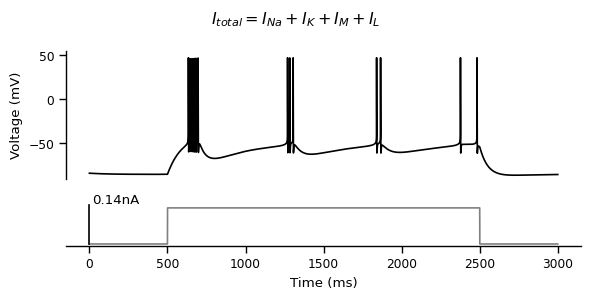

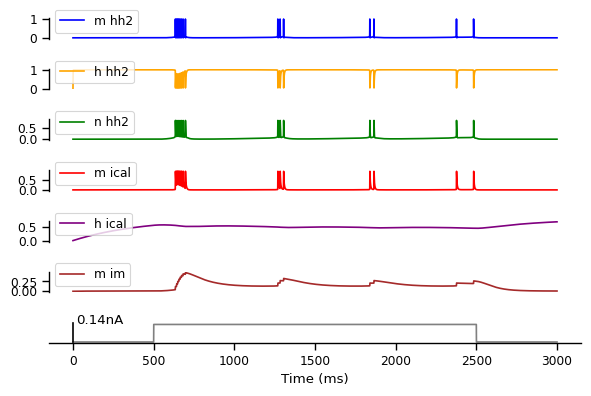

In [16]:
plot_voltage_stim(time,voltage,stim, figsize=(6,3), title='$I_{total} = I_{Na} + I_{K} + I_{M} + I_{L}$')
plot_channels(channels, time, stim, figsize=(6,4))

/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_411845/2079304593.py:34: RuntimeWarning: Mean of empty slice.
  cv = ISI.std() / ISI.mean()
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


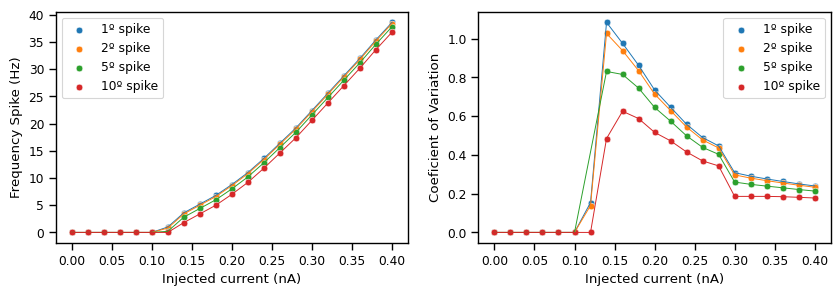

In [17]:
amps, spikes_freq, coef_variation = spikes_analysis(soma, 5000, 0.00, 0.42, step=0.02, mth_spikes=[1,2,5,10])
plot_freq_cv_mthspike(amps, spikes_freq, coef_variation)

## Traub-Miles + Yamada + Reuveni +  low-threshold Calsium current by Destexhe et al. 1998

$$I_\text{total} = I_\text{Na}+ I_\text{K} + I_M + I_L + I_T$$


\begin{equation}
    I_T = \bar{g}_{\text{T}}s_{\infty}^{2}u(V-E_{\text{Ca}}),
\end{equation}

\begin{equation*}
    \frac{du}{dt}= (u_{\infty}(V)-u)/\tau_{u}(V),
\end{equation*}

\begin{equation*}
    s_\infty(V) = \frac{1}{1+\text{exp}[-(V+V_x+57)/6.2]},
\end{equation*}

\begin{equation*}
    u_\infty(V) = \frac{1}{1+\text{exp}[-(V+V_x+81)/4]},
\end{equation*}

\begin{equation*}
    \tau_u(V) = 30.8 + \frac{(211.4+\text{exp}[(V+V_x+113.2)/5])}{3.7(1+\text{exp}[(V+V_x+84)/3.2])},
\end{equation*}

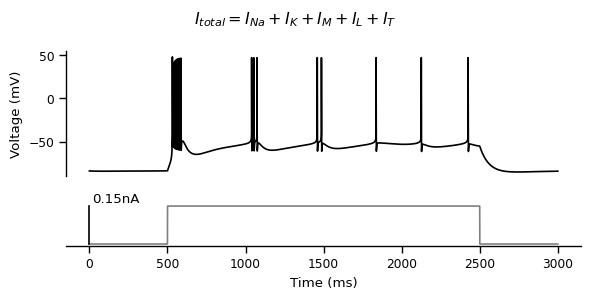

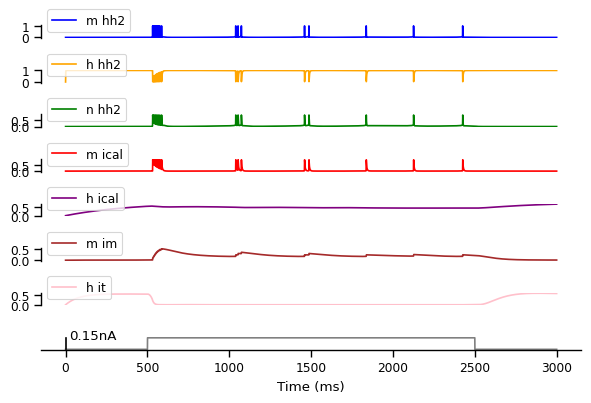

In [21]:
soma = create_soma()
soma = insert_mechanisms(soma, hh2=True, pas=True, im=True, il=True, it=True)
time, voltage, stim, channels = simConfig(soma, 3000, 0.15, 2000, 500, return_channels=True)
plot_voltage_stim(time,voltage,stim, figsize=(6,3), title='$I_{total} = I_{Na} + I_{K} + I_{M}+I_L+I_{T}$')
plot_channels(channels, time, stim, figsize=(6,4))

/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_411845/2079304593.py:34: RuntimeWarning: Mean of empty slice.
  cv = ISI.std() / ISI.mean()
/home/conrado/Documents/trabalhos/chimeras/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


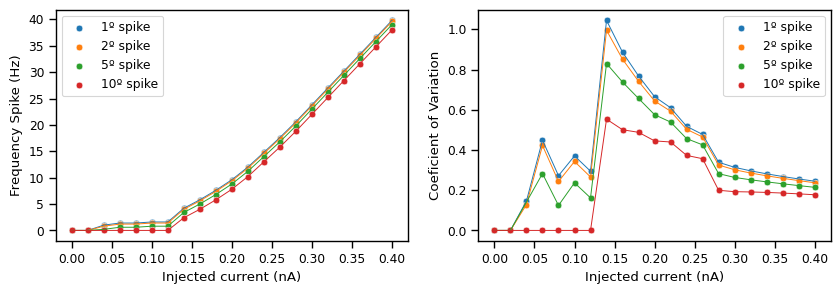

In [19]:
amps, spikes_freq, coef_variation = spikes_analysis(soma, 5000, 0.00, 0.42, step=0.02, mth_spikes=[1,2,5,10])
plot_freq_cv_mthspike(amps, spikes_freq, coef_variation)

In [20]:
babab

NameError: name 'babab' is not defined

# Frequency analysis

In [ ]:
import scipy

def spike_frequency(time, voltage, threshold = 0 ):
    # Definir limiar de disparo
    limiar = threshold  # mV

    # Identificar picos de voltagem
    spikes, _ = scipy.signal.find_peaks(voltage, height=limiar)

    # Calcular a frequência de disparos
    frequencia = len(spikes) / (time[-1] - time[0])  # em Hz m^-3 

    return frequencia

def coefficient_variation(time, voltage, threshold = 0 ):
    # Definir limiar de disparo
    limiar = threshold  # mV

    # Identificar picos de voltagem
    spikes, _ = scipy.signal.find_peaks(voltage, height=limiar)

    spkt = time[spikes]

    ISI = np.array([s - f for f, s in zip(spkt[:], spkt[1:])])
    cv = ISI.std() / ISI.mean()

    return cv

# 2) Networks of hh neurons

the couplings of flux and their fixed poins.

add the extra neurons to insert a noise in the initial conditions.

show the difference in both cases: network with the neurons that insert the noise and without them.

# 3) Chimera States
find the network's parameters where the chimera state is visible.

param global and local order of kuramoto

heatmap of phase $m^{th}$ neuron

# 4) Heatmaps of parameters

standart deviation and mean of chemra's parameters .